In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [2]:
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

In [3]:
df = pd.read_csv('C:/Users/Home/Desktop/Data/2차/CardData_new.csv', encoding = 'cp949')

In [4]:
df2 = df.copy()

In [5]:
d = {
    '21.Active_연속' : 0,
    '22.Active_간헐' : 1,
    '34.휴면_9M+' : 2,
    '32.휴면_6M-' : 2,
    '33.휴면_9M-' : 2,
    '31.휴면_3M' : 2
}
df2['고객구분'] = df2['고객구분'].map(d)

# RFM 0,1 분류

In [6]:
df2['Recency'] = (df[['이용후경과월_신용','이용후경과월_체크', '이용후경과월_카드론']]).min(axis= 1)

In [7]:
df2['Recency_2'] = 0
const = (df2[['이용건수_신용_B0M', '이용건수_체크_B0M', '이용건수_카드론_B0M']].sum(axis = 1)).quantile(0.40)

df2.loc[(df2['Recency'] == 0) & (df2[['이용건수_신용_B0M', '이용건수_체크_B0M', '이용건수_카드론_B0M']].sum(axis = 1) >= const), ['Recency_2']] = 1

In [8]:
df2['Recency_2'].value_counts()

1    183224
0    116776
Name: Recency_2, dtype: int64

In [9]:
df2['Frequency'] = df2['이용건수_신용_R12M'] + df2['이용건수_체크_R12M'] + df2['이용건수_카드론_R12M']

In [10]:
threshold = df2['Frequency'].quantile(0.9)
df2['Frequency_2'] = df2['Frequency'].apply(lambda x: 1 if x >= threshold else 0)

In [11]:
df2['Monetary'] = df2['이용금액_신용_R12M'] + df2['이용금액_체크_R12M'] + df2['이용금액_카드론_R12M'] + df2['이용금액_업종기준']

In [12]:
threshold = df2['Monetary'].quantile(0.9)
df2['Monetary_2'] = df2['Monetary'].apply(lambda x: 1 if x >= threshold else 0)

In [13]:
df2['고객분류_RFM_2'] = '임시'

df2.loc[(df2['Recency_2'] == 1) & (df2['Frequency_2'] == 1) & (df2['Monetary_2'] == 1), ['고객분류_RFM_2']] = 'VIP고객'
df2.loc[(df2['Recency_2'] == 1) & (df2['Frequency_2'] == 1) & (df2['Monetary_2'] == 0), ['고객분류_RFM_2']] = '충성고객'
df2.loc[(df2['Recency_2'] == 1) & (df2['Frequency_2'] == 0) & (df2['Monetary_2'] == 1), ['고객분류_RFM_2']] = '잠재VIP고객'
df2.loc[(df2['Recency_2'] == 1) & (df2['Frequency_2'] == 0) & (df2['Monetary_2'] == 0), ['고객분류_RFM_2']] = '잠재충성고객'
df2.loc[(df2['Recency_2'] == 0) & (df2['Frequency_2'] == 1) & (df2['Monetary_2'] == 1), ['고객분류_RFM_2']] = '놓치면안될고객'
df2.loc[(df2['Recency_2'] == 0) & (df2['Frequency_2'] == 1) & (df2['Monetary_2'] == 0), ['고객분류_RFM_2']] = '관심필요고객'
df2.loc[(df2['Recency_2'] == 0) & (df2['Frequency_2'] == 0) & (df2['Monetary_2'] == 1), ['고객분류_RFM_2']] = '이탈우려고객'
df2.loc[(df2['Recency_2'] == 0) & (df2['Frequency_2'] == 0) & (df2['Monetary_2'] == 0), ['고객분류_RFM_2']] = '겨울잠고객'

In [14]:
df2['고객분류_RFM_2'].value_counts()

잠재충성고객     138529
겨울잠고객      114367
충성고객        16767
잠재VIP고객     15001
VIP고객       12927
이탈우려고객       2000
관심필요고객        337
놓치면안될고객        72
Name: 고객분류_RFM_2, dtype: int64

In [15]:
df2['고객분류_RFM_2'].value_counts()

잠재충성고객     138529
겨울잠고객      114367
충성고객        16767
잠재VIP고객     15001
VIP고객       12927
이탈우려고객       2000
관심필요고객        337
놓치면안될고객        72
Name: 고객분류_RFM_2, dtype: int64

# RFM 5개 값 분류

In [16]:
df2['Recency_5'] = (df[['이용후경과월_신용','이용후경과월_체크', '이용후경과월_카드론']]).min(axis= 1)

In [17]:
df2['Recency_5'].value_counts().sort_index()

0     243637
1       8549
2       5339
3       4252
4       3121
5       2768
6       2468
7       2273
8       1903
9       1721
10      1644
11      1539
12     20786
Name: Recency_5, dtype: int64

In [18]:
df2['Recency_5'] = df2['Recency'].map(lambda x : {0 : 5, 1 : 4, 2 :4, 3 : 4, 4: 3, 5:3, 6:3, 7:2, 8:2, 9:2, 10:1, 11:1, 12:1}[x])

In [19]:
df2['Frequency_5'] = pd.cut(df2['Frequency'], bins = [df2['Frequency'].quantile(0), df2['Frequency'].quantile(0.2), df2['Frequency'].quantile(0.4),
                                 df2['Frequency'].quantile(0.6), df2['Frequency'].quantile(0.8), df2['Frequency'].quantile(1)],
      labels = [1, 2, 3, 4, 5], include_lowest = True)

In [20]:
df2['Monetary_5'] = pd.cut(df2['Monetary'], bins = [df2['Monetary'].quantile(0), df2['Monetary'].quantile(0.2), df2['Monetary'].quantile(0.4),
                                 df2['Monetary'].quantile(0.6), df2['Monetary'].quantile(0.8), df2['Monetary'].quantile(1)],
      labels = [1, 2, 3, 4, 5], include_lowest = True)

In [21]:
scaler = MinMaxScaler()
df2['Recency_s'] = scaler.fit_transform(df2[['Recency']])
df2['Frequency_s'] = scaler.fit_transform(df2[['Frequency']])
df2['Monetary_s'] = scaler.fit_transform(df2[['Monetary']])

C:\Users\Home\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Home\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Home\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Home\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

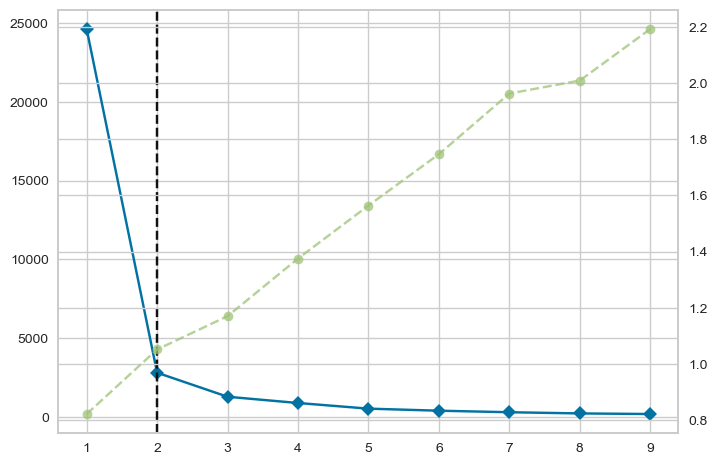

In [25]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(df2[['Recency_s','Frequency_s','Monetary_s']])
# k = 2

In [29]:
# KMeans 모델 생성 (k=2)
kmeans = KMeans(n_clusters=2)
# 모델 학습 및 예측
labels = kmeans.fit_predict(df2[['Recency_s','Frequency_s','Monetary_s']])

C:\Users\Home\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [36]:
df2['labels_k'] = labels

In [37]:
df2.loc[df2['labels_k'] == 0, 'Recency_s'].mean()

0.018152909471754602

In [38]:
df2.loc[df2['labels_k'] == 1, 'Recency_s'].mean()

0.8871801612337888

In [39]:
df2.groupby('labels_k')[['Recency_s', 'Frequency_s', 'Monetary_s']].agg('mean')

,Recency_s,Frequency_s,Monetary_s
labels_k,,,
0,0.018153,0.045819,0.002663
1,0.887180,0.004693,0.001014


In [45]:
# CV = k개 그룹에 대한 각 R,F,M의 표준편차 / 평균
cv_k = df2.groupby('labels_k')[['Recency_s', 'Frequency_s', 'Monetary_s']].agg('std')/df2.groupby('labels_k')[['Recency_s', 'Frequency_s', 'Monetary_s']].agg('mean')
cv_k

,Recency_s,Frequency_s,Monetary_s
labels_k,,,
0,3.707733,1.040649,1.242323
1,0.195777,1.055173,0.395543


In [48]:
CV = cv_k.sum().sum()
CV

7.637197271068573

In [52]:
res2 = cv_k.min(axis = 0) / CV
res2

Recency_s      0.025635
Frequency_s    0.136261
Monetary_s     0.051792
dtype: float64

In [59]:
# 가중치
w1, w2, w3 = (res2 / res2.sum())
print(w1, w2, w3)

0.11996361044922198 0.6376649358629156 0.2423714536878624


In [58]:
df2

0.11996361044922198

In [60]:
df2['RFM_Score'] = w1 * df2['Recency'] + w2 * df2['Frequency'] + w3 * df2['Monetary']

In [63]:
df2['RFM_Class'] = pd.qcut(df2['RFM_Score'], q = 8, labels = ['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객',
                                                              '잠재충성고객','잠재VIP고객','충성고객','VIP고객'])

In [64]:
df2['RFM_Class'].value_counts()

겨울잠고객      37500
이탈우려고객     37500
관심필요고객     37500
놓치면안될고객    37500
잠재충성고객     37500
잠재VIP고객    37500
충성고객       37500
VIP고객      37500
Name: RFM_Class, dtype: int64

In [76]:
df2.loc[df2['RFM_Class']=='잠재VIP고객','고객구분'].value_counts()

0    34428
1     2006
2     1066
Name: 고객구분, dtype: int64